In [1]:
import warnings
warnings.filterwarnings('ignore')
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr
warnings.filterwarnings('ignore')
from satlib import corcor



/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [2]:
# define GPM data set
gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5'

gpm_file = wrl.util.get_wradlib_data_file(gpm_file_path)

# define matching ground radar file
gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_010deg/2014-10-07--02:37:44,00.mvol'
#gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_010deg/2014-10-08--09:45:00,00.mvol'

gr2gpm_file = wrl.util.get_wradlib_data_file(gr_file_path)

In [3]:
# Space-born precipitation radar parameters
sr_pars = {"gpm": {
    "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
    "gr_file": gr2gpm_file,
}}

In [4]:
# Set parameters for this procedure
bw_sr = 0.71                  # SR beam width
platf = "gpm"                 # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]




In [5]:
def read_gr_boxpol(filename, loaddata=True):
    """
    Read ground radar boxpol scans
    
    in arbeit....
    zur zeit nur ein scan (1.5)
    """
    sdate = []
    refl = []
    
    gr_data = wrl.io.read_generic_netcdf(gr_file)
    grdata, grattrs = wrl.io.read_GAMIC_hdf5(gr_file)
    print gr_file
    
    dat_ = gr_data['what']['date']
    print dat_
    dat = dat_[0:10]
    tim = dat_[11:-1]
    print (dat, tim)
    # '2014-10-07T02:42:02Z'
    date = dt.datetime.strptime(dat + tim, "%Y-%d-%m%H:%M:%S")
    #source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    import glob
    c_liste = glob.glob(gr_file.replace('n_ppi_010deg','*ppi*'))
    print c_liste
    ntilt = len(c_liste)
    
    ref_data = [[]]*ntilt
    rho_data = [[]]*ntilt


    print ('ntilit:',ntilt)    
    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)
    
    for jj in range(ntilt):
        print c_liste[jj]
        
        gr_data = wrl.io.read_generic_netcdf(c_liste[jj])
        grdata, grattrs = wrl.io.read_GAMIC_hdf5(c_liste[jj])

        #for i in range(0, ntilt):
        dset = gr_data['scan0']
        # Azimuth Start
        a0[jj] = dset['how']['azi_start'] 
        # Elevations Winkel
        elang[jj] = dset['how']['elevation']
        # Anzahl bins
        ngate[jj] = dset['how']['bin_count']
        # Start und Step der range
        r0[jj] = dset['how']['range_start']
        dr[jj] = dset['how']['range_step']
        # Anzahl Rays
        nbeam[jj] = dset['how']['ray_count']

        #print ('azi start: ', a0)    
        #print ('elevation: ', elang)    
        #print ('bin count: ', ngate)    
        #print ('range start: ', r0)    
        #print ('range step: ', dr)    
        #print ('ray count: ', nbeam)    


        gr_dict = {}
        gr_dict.update({'date': date, 'lon': lon, 'lat': lat,
                        'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                        'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
        if not loaddata:
            return gr_dict



        #for i in range(0, ntilt):
            #dset = gr_data['scan0']
            #data = dset['variables']['moment_10']['data']

        data = grdata['SCAN0']['ZH']['data']
        rho = grdata['SCAN0']['RHOHV']['data']
        

        #refl.append(data)
        ref_data[jj]=data
        rho_data[jj]=rho
        #ref_data[ref_data<=0]=np.nan

        #refl1 = np.array(refl)
    gr_dict.update({'refl': ref_data})
    gr_dict.update({'rho': rho_data})
    
    return gr_dict, ntilt



In [6]:
# read matching GR data
gr_data, ntilt = read_gr_boxpol(gr_file)


/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_010deg/2014-10-07--02:37:44,00.mvol
2014-10-07T02:42:36Z
(u'2014-10-07', u'02:42:36')
['/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_010deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_045deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_082deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_110deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_140deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_180deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/n_ppi_280deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_1p5deg/2014-10-07--02:37:44,00.mvol', '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_2p4d

# Beginn der QnD shitty For schleife

In [7]:
SR, GR =  np.array([]), np.array([])
X, Y, Z = np.array([]), np.array([]), np.array([])

gr_nr_elev, gr_ele = np.array([]), np.array([])


for ijk in range(ntilt):
#for ijk in range(1,6,2):

    ######### GR data and att
    ee = ijk
    # number of rays in gr sweep
    nray_gr = gr_data['nbeam'].astype("i4")[ee]
    # number of gates in gr beam
    ngate_gr = gr_data['ngate'].astype("i4")[ee]
    # number of sweeps
    nelev = gr_data['ntilt']
    # elevation of sweep (degree)
    elev_gr = gr_data['elang'][ee]
    # gate length (meters)
    dr_gr = gr_data['dr'][ee]
    # sweep datetime stamp
    #date_gr = gr_data['sdate'][ee]
    # range of first gate
    r0_gr = gr_data['r0'][ee]
    # azimuth angle of first beam
    a0_gr = gr_data['a0'][ee]
    # Longitude of GR
    lon0_gr = gr_data['lon']
    # Latitude of GR
    lat0_gr = gr_data['lat']
    # Altitude of GR (meters)
    alt0_gr = gr_data['alt']
    # Beam width of GR (degree)
    bw_gr = 1.
    # reflectivity array of sweep
    ref_gr = gr_data['refl'][ee]
    # rhohv array of sweep
    rho_gr = gr_data['rho'][ee]
    
    if elev_gr<5:
        print ("Elevation zu niedrig")
        pass
    else:
        ############################################################################## Korrektur der GR Daten
        print ("________Offset______")
        #Hardcoded....passt in etwa
        #ref_gr = ref_gr + 2


        print ("________ATTCORR______")
        pia_harrison = wrl.atten.correctAttenuationHB(
            ref_gr,
            coefficients = dict(a=4.57e-5, b=0.731, gate_length=1.0),
            mode="warn",
            thrs=59.)
        pia_harrison[pia_harrison > 4.8] = 4.8

        print ("________ATTCORR2______")
        ref_gr = ref_gr + pia_harrison


        print ("________CLUTTER______")
        rho_th  = 0.85
        ref_gr[rho_gr<= rho_th] = np.nan

        print ("________TH______")
        TH = 15
        ref_gr[ref_gr<=TH]=np.nan

        print ('----ref_gr: ',np.unique(ref_gr))

        coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
        coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                              np.degrees(coord[..., 1]),
                                              coord[..., 2],
                                              (lon0_gr, lat0_gr, alt0_gr))
        lon = coords[..., 0]
        lat = coords[..., 1]
        alt = coords[..., 2]
        bbox = wrl.zonalstats.get_bbox(lon, lat)
        print("Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f" %
              (bbox['top'], bbox['left'], bbox['right'], bbox['bottom']))
        sr_data = wrl.io.read_gpm(gpm_file, bbox)

        # Longitudes of SR scans
        sr_lon = sr_data['lon']
        # Latitudes of SR scans
        sr_lat = sr_data['lat']
        # Precip flag
        pflag = sr_data['pflag']
        # Number of scans on SR data
        nscan_sr= sr_data['nscan']
        # Number of rays in one SR scan
        nray_sr = sr_data['nray']
        # Number of gates in one SR ray
        ngate_sr = sr_data['nbin']

        # Calculate equivalent earth radius
        wgs84 = wrl.georef.get_default_projection()
        re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84)
        #print("Earth radius 1:", re1)
        a = wgs84.GetSemiMajor()
        b = wgs84.GetSemiMinor()
        #print("SemiMajor, SemiMinor:", a, b)

        # Set up aeqd-projection gr-centered
        rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                                           '+lat_0={lat:f} +a={a:f} ' +
                                           '+b={b:f}').format(lon=lon0_gr,
                                                              lat=lat0_gr,
                                                              a=a, b=b))
        re2 = wrl.georef.get_earth_radius(lat0_gr, rad)
        #print("Earth radius 2:", re2)

        # create gr range and azimuth arrays
        rmax_gr = r0_gr + ngate_gr * dr_gr
        r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
        az_gr = np.arange(0, nray_gr) - a0_gr
        print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)

        # create gr polar grid and calculate aeqd-xyz coordinates
        gr_polargrid = np.meshgrid(r_gr, az_gr)
        gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ))
        print("XYZ-Grid-Shape:", gr_xyz.shape)

        # create gr poygon array in aeqd-xyz-coordinates
        gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
        print(gr_poly.shape, 360 * 600)
        gr_poly.shape = (nray_gr, ngate_gr, 5, 3)

        # get radar domain (outer ring)
        gr_domain = gr_xyz[:,-1,0:2]
        gr_domain = np.vstack((gr_domain, gr_domain[0]))
        print("Domain-Shape:", gr_domain.shape)

        sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat,
                                          projection_source=wgs84,
                                          projection_target=rad)
        sr_xy = np.dstack((sr_x, sr_y))
        print("SR-GRID-Shapes:", sr_x.shape, sr_y.shape, sr_xy.shape)

        precip_mask = (pflag >= 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

        print("NRAY", nray_sr)
        print("NBIN", ngate_sr)

        # use localZenith Angle
        alpha = sr_data['zenith']
        beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

        # Correct for parallax, get 3D-XYZ-Array
        #   xyzp_sr: Parallax corrected xyz coordinates
        #   r_sr_inv: range array from ground to SR platform
        #   zp: SR bin altitudes
        xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
        print(xyp_sr.shape, r_sr_inv.shape, z_sr.shape)
        xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                           axis=-1)
        r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)
        #TODO: hardcoded 1.0
        mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))

        rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)

        # Small anngle approximation
        vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2

        # Or using wradlib's native function
        vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)

        # GR pulse volumes
        #   along one beam
        vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
        #   with shape (nray_gr, ngate_gr)
        vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

        Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))
        Ds = dr_sr / np.cos(np.radians(alpha))
        Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

        ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)

        zbb = sr_data['zbb'].copy()
        zbb[~ibb] = np.nan

        ref_sr = sr_data['refl'].filled(np.nan)


        # First assumption: no valid SR bins (all False)
        valid = np.asarray(elev_sr, dtype=np.bool)==False
        print(valid.shape, precip_mask.shape)

        # SR is inside GR range and is precipitating
        iscan = precip_mask.nonzero()[0]
        iray = precip_mask.nonzero()[1]
        valid[iscan,iray] = True

        # SR bins intersect with GR sweep
        valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))

        # Number of matching SR bins per profile
        nvalids = np.sum(valid, axis=2)

        # scan and ray indices for profiles with at least one valid bin
        vscan, vray = np.where(nvalids>0)

        # number of profiles with at least one valid bin
        nprof = len(vscan)

        # average coordinates
        xyz_v1 = xyzp_sr.copy()
        print(xyz_v1.shape)
        xyz_v1[~valid] = np.nan
        xyz_c1 = xyzp_sr.copy()
        xyz_c1[~valid] = 0
        c = np.count_nonzero(xyz_c1[..., 0], axis=2)
        ntotsr = c[vscan, vray]
        xyz_m1 = np.nanmean(xyz_v1,axis=2)
        xyz = xyz_m1[vscan, vray]
        print(xyz.shape, c.shape)

        # approximate Rs
        rs_v1 = Rs.copy()
        rs_v1[~valid] = np.nan
        rs_m1 = np.nanmax(rs_v1, axis=2)
        rs_prof = rs_m1[vscan, vray]
        ds = rs_prof

        # approximate Ds
        ds_v1 = Ds.copy()
        ds_v1[~valid] = np.nan
        ds_m1 = np.nansum(ds_v1, axis=2)
        ds_prof = ds_m1[vscan, vray]
        dz = ds_prof

        # approximate Vs
        vs_v1 = vol_sr.copy()
        vs_v1[~valid] = np.nan
        vs_m1 = np.nansum(vs_v1, axis=2)
        vs_prof = vs_m1[vscan, vray]
        volsr1 = vs_prof

        r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)

        ref_sr_1 = wrl.trafo.idecibel(ref_sr)
        ref_sr_1[~valid] = np.nan
        refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
        refsr1a = wrl.trafo.decibel(refsr1a)


        zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)


        tmp_trg_lyr = zds.ds.GetLayer()
        trg_poly = []
        for i, feat in enumerate(tmp_trg_lyr):
            geom = feat.GetGeometryRef().Buffer(rs_prof[i])
            poly = wrl.georef.ogr_to_numpy(geom)
            trg_poly.append(poly)    

        zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
        zdp.dump_vector('m3d_zonal_poly_{0}'.format(platf))

        obj3 = wrl.zonalstats.GridCellsToPoly('m3d_zonal_poly_{0}'.format(platf))

        print(obj3.ix.shape)
        volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                           for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        print(volgr1.shape)

        ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())
        #ref_gr_ku_i = wrl.trafo.idecibel(ref_gr_ku.ravel())
        refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
                     for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
        refgr1a = wrl.trafo.decibel(refgr1a)

        print ('Durchgang: ', ijk)

        pl.figure(figsize=(14,14))
        pl.scatter(refsr1a,refgr1a, label=str(elev_gr))
        pl.legend(loc='upper left')
        pl.xlabel('SR in dbz')
        pl.ylabel('GR in dbz')
        pl.title(corcor(refsr1a,refgr1a))
        pl.xlim(0,45)
        pl.ylim(0,45)
        pl.plot([0,45],[0,45], color='black', ls='--')
        pl.grid()
        #pl.colorbar() 
        pl.savefig('/automount/ftp/velibor/validation/match_ele'+str(elev_gr)+'.png')
        pl.close()

        X = np.append(X,xyz[...,0])
        Y = np.append(Y,xyz[...,1])
        Z = np.append(Z,xyz[...,2])

        SR = np.append(SR, refsr1a)
        GR = np.append(GR, refgr1a)

        gr_nr_elev = np.append(gr_nr_elev, refgr1a.shape)
        gr_ele = np.append(gr_ele, elev_gr)



    

    
    

Elevation zu niedrig
Elevation zu niedrig
________Offset______
________ATTCORR______
________ATTCORR2______
________CLUTTER______
________TH______
('----ref_gr: ', array([15.00023103, 15.00044942, 15.00186038, ...,         nan,
               nan,         nan]))
Radar bounding box:
	51.71
5.53           8.61
	49.75
('Range/Azi-Shape:', (1100,), (360,))
('XYZ-Grid-Shape:', (360, 1100, 3))
((396000, 5, 3), 216000)
('Domain-Shape:', (361, 2))
('SR-GRID-Shapes:', (63, 49), (63, 49), (63, 49, 2))
('NRAY', 49)
('NBIN', 176)
((63, 49, 176, 2), (176,), (63, 49, 176))
((63, 49, 176), (63, 49))
(63, 49, 176, 3)
((1125, 3), (63, 49))
(1125,)
(1125,)
('Durchgang: ', 2)
________Offset______
________ATTCORR______
________ATTCORR2______
________CLUTTER______
________TH______
('----ref_gr: ', array([15.00068164, 15.00102472, 15.00111675, ...,         nan,
               nan,         nan]))
Radar bounding box:
	51.17
6.38           7.77
	50.29
('Range/Azi-Shape:', (1000,), (360,))
('XYZ-Grid-Shape:', (

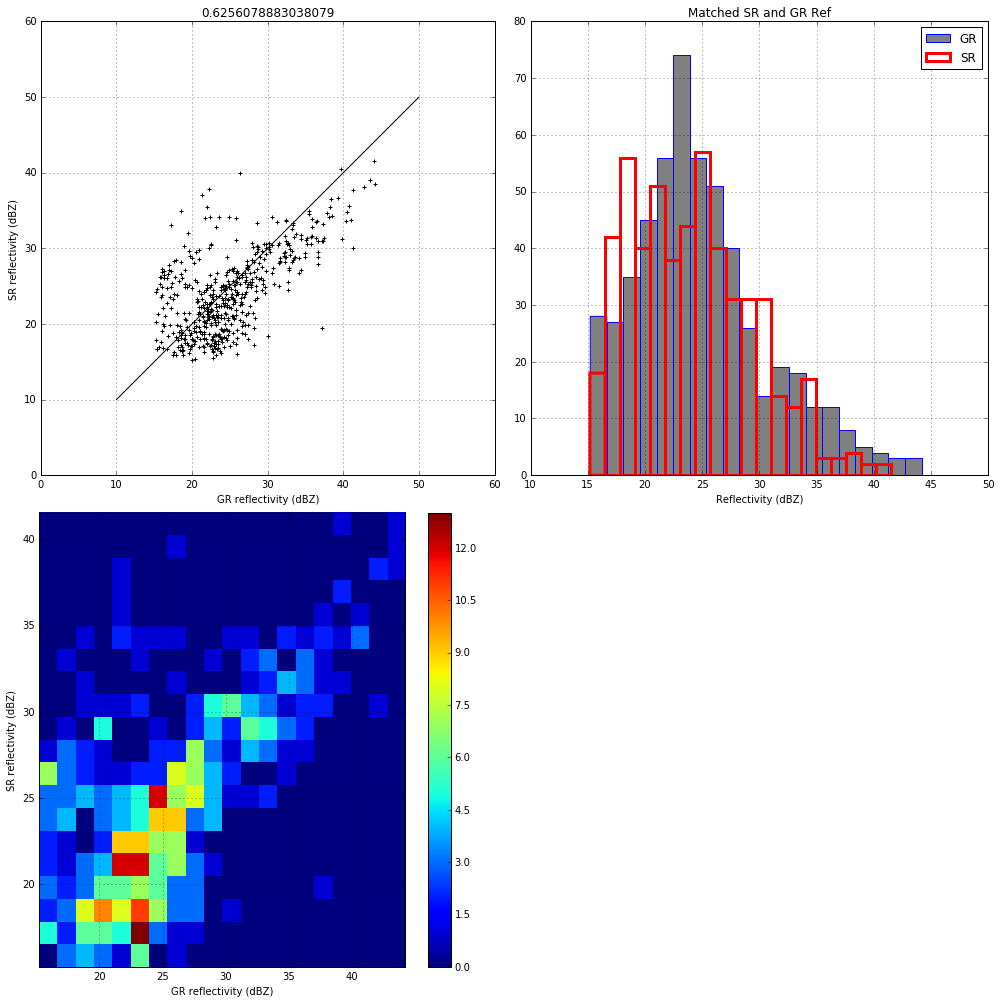

In [8]:
from satlib import corcor
from pcc import get_miub_cmap
TH = 15
SR[SR<=TH]=np.nan
GR[GR<=TH]=np.nan


fig = pl.figure(figsize=(14,14))
ax = fig.add_subplot(221, aspect="equal")
pl.scatter(GR, SR, marker="+", c="black")
pl.plot([10,50],[10,50], linestyle="solid", color="black")
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.grid()
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
pl.title(corcor(GR, SR))

ax = fig.add_subplot(222)
m0 = ~np.isnan(GR)& ~np.isnan(SR)

pl.hist(GR[m0], bins=20, edgecolor="blue", facecolor="grey", label="GR")
pl.hist(SR[m0], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Matched SR and GR Ref')
pl.xlim(10,50)

ax = fig.add_subplot(223)
pl.hist2d(GR[m0], SR[m0],bins=20)

pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.colorbar()
#pl.xlim(10,50)



pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching1.png')

('Corellation: ', '0.6256078883038079')


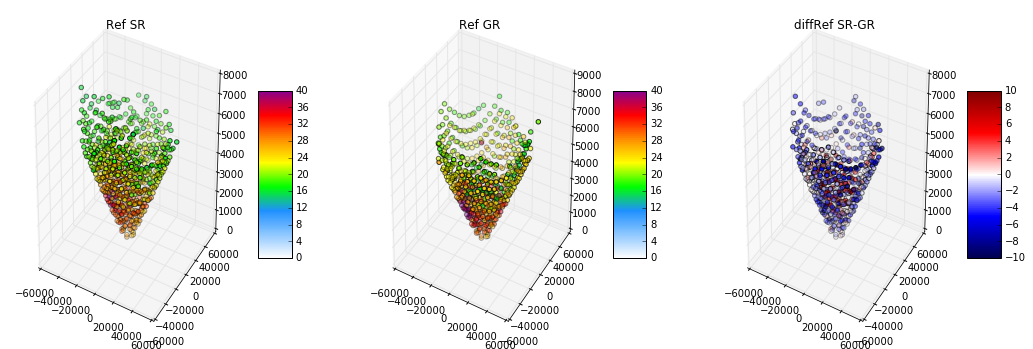

In [28]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
pppl = ax1.scatter(X, Y, Z, c=SR.ravel(), vmin=0, vmax=40, cmap=get_miub_cmap())
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax1.set_title('Ref SR')

ax2 = fig.add_subplot(132, projection='3d')
pppl = ax2.scatter(X, Y, Z, c=GR.ravel(), vmin=0, vmax=40, cmap=get_miub_cmap())
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax2.set_title('Ref GR')

ax3 = fig.add_subplot(133, projection='3d')
pppl = ax3.scatter(X, Y, Z, c=SR.ravel()-GR.ravel(),
                   cmap='seismic',vmin=-10,vmax=10)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax3.set_title('diffRef SR-GR')

from satlib import corcor
print ('Corellation: ',corcor( SR, GR))
pl.savefig('/automount/ftp/velibor/validation/matching2.png')

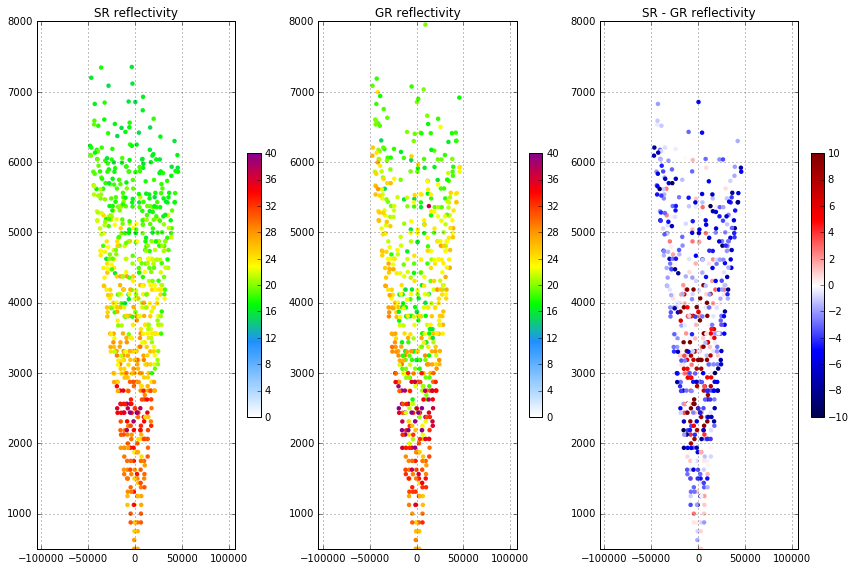

In [10]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(Y,Z, c=SR,  vmin=0, vmax=40, edgecolor="None", cmap=get_miub_cmap())
pl.title("SR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(Y,Z, c=GR,  vmin=0, vmax=40, edgecolor="None", cmap=get_miub_cmap())
pl.title("GR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(Y,Z, c=SR-GR, cmap='seismic',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(Y),np.nanmax(Y))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching3.png')

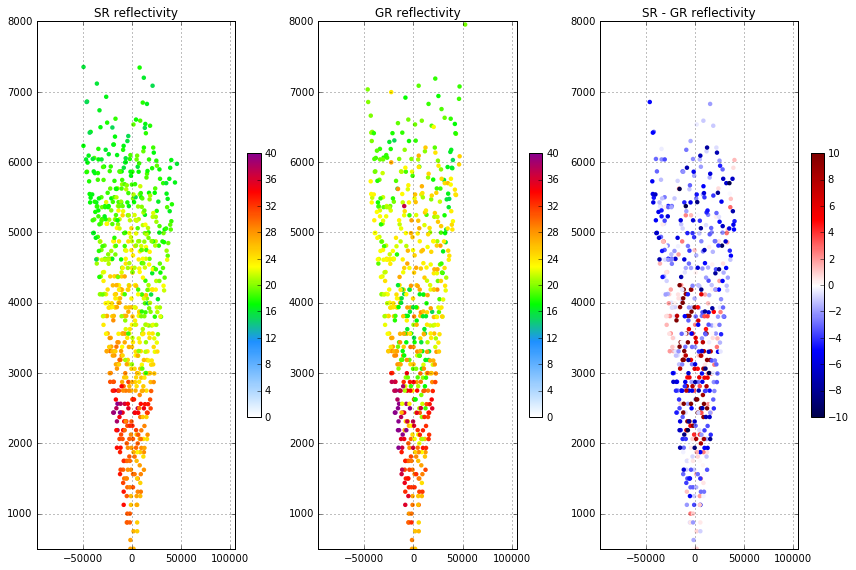

In [11]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(X,Z, c=SR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(X,Z, c=GR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(X,Z, c=SR-GR, cmap='seismic',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Z),8000)
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching4.png')

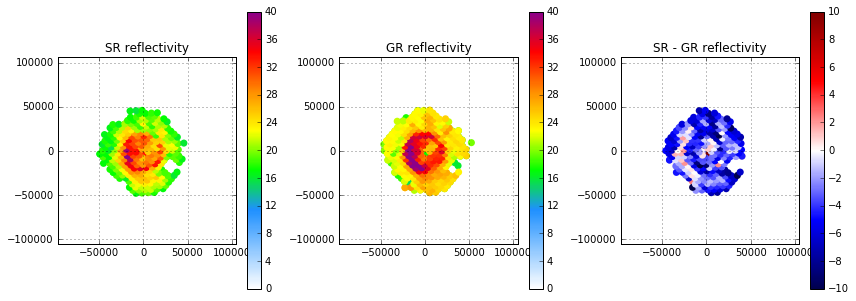

In [12]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(X,Y, c=SR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None",s=50)
pl.title("SR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(X,Y, c=GR, cmap=get_miub_cmap(), vmin=0, vmax=40, edgecolor="None",s=50)
pl.title("GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(X,Y, c=SR-GR, cmap='seismic',vmin=-10,vmax=10 ,edgecolor="None",s=50)
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(X),np.nanmax(X))
pl.ylim(np.nanmin(Y),np.nanmax(Y))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/matching5.png')

In [13]:
def plot_cfad(x1, x2, ZP):
    """
    Plot 4 CFAD
    """
    import matplotlib.pyplot as plt
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])

    hh = np.array([])
    for jj in range(0,20000,100):
        hh = np.append(hh,jj)
        x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
    
    plt.figure(figsize=(12,12)) 
    plt.hexbin(x1[m1], x2[m1],bins=10, cmap='inferno')
    plt.colorbar()
    plt.xlabel('ZH in DBz')
    plt.ylabel('Height in m')
    plt.title('CFAD: '+ ZP)
    plt.plot(x3,hh, linewidth=2, label='mean')
    plt.plot(x4,hh, linewidth=2, label='median')
    plt.ylim(0,10000)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(color='white')
    #plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/boxpol_cfad_'+ZP+'.png')
    #plt.close()
    #plt.ylim(0,)
    plt.show()



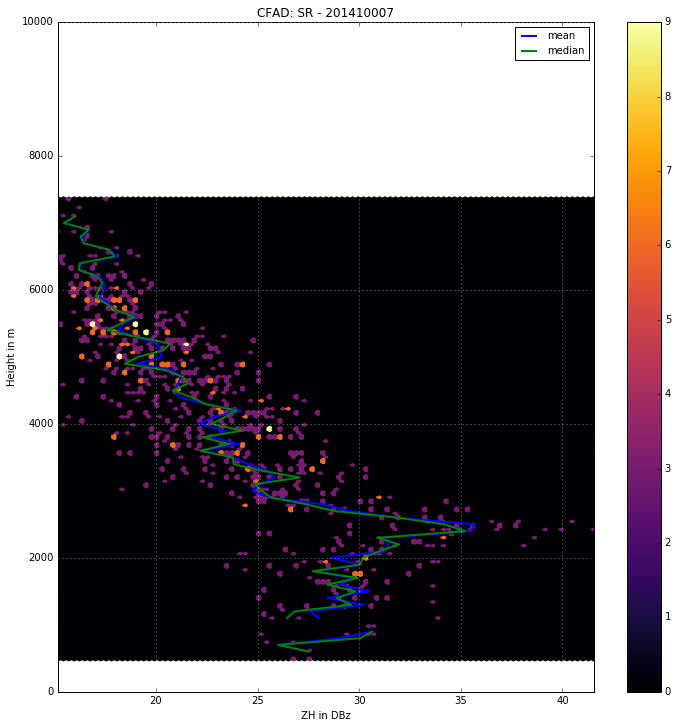

In [14]:
plot_cfad(SR,Z,'SR - 201410007')
pl.savefig('/automount/ftp/velibor/validation/cfadSR.png')



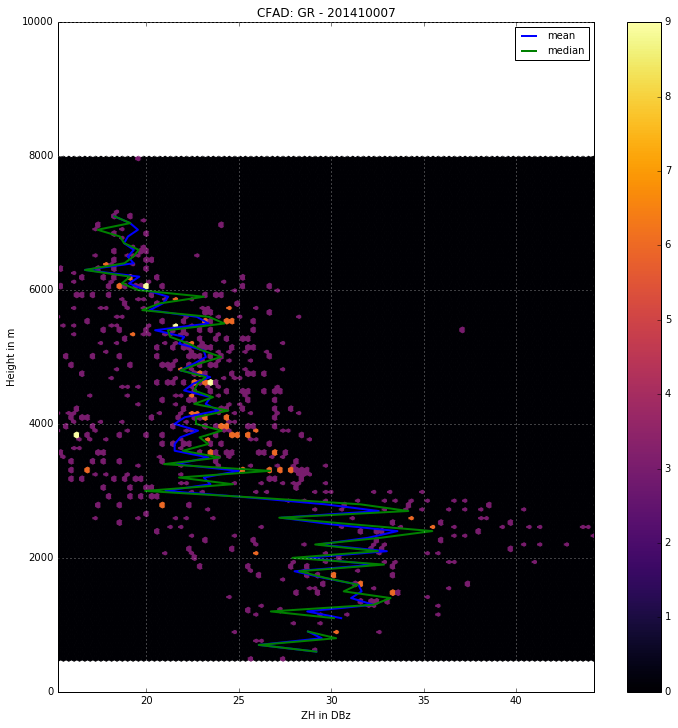

In [15]:
plot_cfad(GR,Z,'GR - 201410007')
pl.savefig('/automount/ftp/velibor/validation/horizontal_corr_X.png')


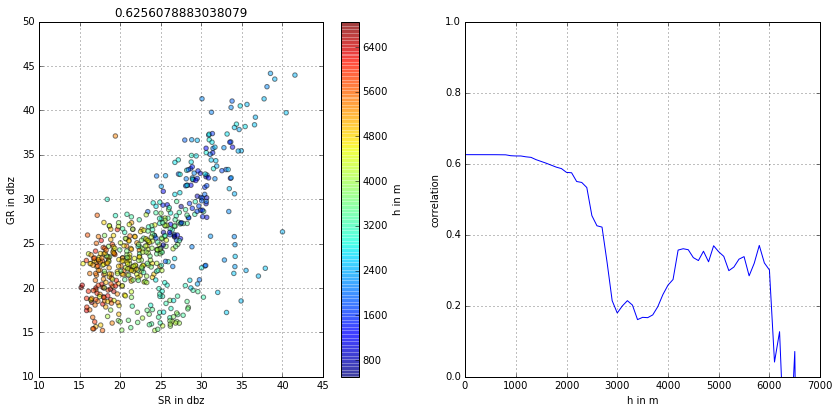

In [16]:
hhh=0

h = np.arange(0,15000,100)
cor = np.array([])
for ccc in h:
    cor = np.append(cor,corcor(SR[Z>ccc],GR[Z>ccc]))

                    
#       
pl.figure(figsize=(14,14))
pl.subplot(2,2,1)
pl.scatter(SR[Z>hhh],GR[Z>hhh],c=Z[Z>hhh],alpha=0.5)
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[Z>hhh],GR[Z>hhh]))
cb = pl.colorbar()
cb.set_label('h in m')
pl.grid()
            
pl.subplot(2,2,2)
pl.plot(h,cor)
pl.grid()
pl.ylim(0,1)
pl.xlabel('h in m')
pl.ylabel('correlation')

pl.savefig('/automount/ftp/velibor/validation/vertical_corr_Z.png')



In [17]:
"""aa=0.9

pl.figure(figsize=(16,10))
pl.subplot(2,5,1)
pl.scatter(SR[0:629],GR[0:629],alpha=aa,label='ele: 0.10',color='black')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[0:629],GR[0:629]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,5)
pl.scatter(SR[629:1254],GR[629:1254],alpha=aa,label='ele: 4.50',color='blue')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[629:1254],GR[629:1254]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,6)
pl.scatter(SR[1254:2379],GR[1254:2379],alpha=aa,label='ele: 8.20',color='green')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[1254:2379],GR[1254:2379]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,7)
pl.scatter(SR[2379:2676],GR[2379:2676],alpha=aa,label='ele: 11.0',color='tan')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[2379:2676],GR[2379:2676]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,8)
pl.scatter(SR[2676:2861],GR[2676:2861],alpha=aa,label='ele: 14.0',color='red')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[2676:2861],GR[2676:2861]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,9)
pl.scatter(SR[2861:2944],GR[2861:2944],alpha=aa,label='ele: 18.0',color='gray')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[2861:2944],GR[2861:2944]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,10)
pl.scatter(SR[2944:2950],GR[2944:2950],alpha=aa,label='ele: 28.0',color='orange')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[2944:2950],GR[2944:2950]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,2)
pl.scatter(SR[2950:3252],GR[2950:3252],alpha=aa,label='ele: 1.5',color='brown')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[2950:3252],GR[2950:3252]))
pl.grid()
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.subplot(2,5,3)
pl.scatter(SR[3252:3554],GR[3252:3554],alpha=aa,label='ele: 2.5',color='cyan')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[3252:3554],GR[3252:3554]))
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')
pl.grid()

pl.subplot(2,5,4)
pl.scatter(SR[3554:3854],GR[3554:3854],alpha=aa,label='ele: 3.4',color='magenta')
pl.legend(loc='upper left')
pl.xlabel('SR in dbz')
pl.ylabel('GR in dbz')
pl.title(corcor(SR[3554:3854],GR[3554:3854]))
pl.xlim(0,45)
pl.ylim(0,45)
pl.plot([0,45],[0,45], color='black', ls='--')

pl.grid()
pl.savefig('/automount/ftp/velibor/validation/corr_elev.png')"""

"aa=0.9\n\npl.figure(figsize=(16,10))\npl.subplot(2,5,1)\npl.scatter(SR[0:629],GR[0:629],alpha=aa,label='ele: 0.10',color='black')\npl.legend(loc='upper left')\npl.xlabel('SR in dbz')\npl.ylabel('GR in dbz')\npl.title(corcor(SR[0:629],GR[0:629]))\npl.grid()\npl.xlim(0,45)\npl.ylim(0,45)\npl.plot([0,45],[0,45], color='black', ls='--')\n\npl.subplot(2,5,5)\npl.scatter(SR[629:1254],GR[629:1254],alpha=aa,label='ele: 4.50',color='blue')\npl.legend(loc='upper left')\npl.xlabel('SR in dbz')\npl.ylabel('GR in dbz')\npl.title(corcor(SR[629:1254],GR[629:1254]))\npl.grid()\npl.xlim(0,45)\npl.ylim(0,45)\npl.plot([0,45],[0,45], color='black', ls='--')\n\npl.subplot(2,5,6)\npl.scatter(SR[1254:2379],GR[1254:2379],alpha=aa,label='ele: 8.20',color='green')\npl.legend(loc='upper left')\npl.xlabel('SR in dbz')\npl.ylabel('GR in dbz')\npl.title(corcor(SR[1254:2379],GR[1254:2379]))\npl.grid()\npl.xlim(0,45)\npl.ylim(0,45)\npl.plot([0,45],[0,45], color='black', ls='--')\n\npl.subplot(2,5,7)\npl.scatter(SR[2

In [18]:
"""aa=0.9
from pcc import get_miub_cmap
pl.figure(figsize=(30,10))
pl.subplot(2,5,1)
pl.scatter(X[0:629],Y[0:629],c=GR[0:629], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)


pl.subplot(2,5,5)
pl.scatter(X[629:1254],Y[629:1254],c=GR[629:1254], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,6)
pl.scatter(X[1254:2379],Y[1254:2379],c=GR[1254:2379], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,7)
pl.scatter(X[2379:2676],Y[2379:2676],c=GR[2379:2676], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,8)
pl.scatter(X[2676:2861],Y[2676:2861],c=GR[2676:2861], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,9)
pl.scatter(X[2861:2944],Y[2861:2944],c=GR[2861:2944], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,10)
pl.scatter(X[2944:2950],Y[2944:2950],c=GR[2944:2950], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)

pl.subplot(2,5,2)
pl.scatter(X[2950:3252],Y[2950:3252],c=GR[2950:3252], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)


pl.subplot(2,5,3)
pl.scatter(X[3252:3554],Y[3252:3554],c=GR[3252:3554], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.grid()
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)


pl.subplot(2,5,4)
pl.scatter(X[3554:3854],Y[3554:3854],c=GR[3554:3854], cmap=get_miub_cmap(), vmin=0, vmax=40)
pl.colorbar()
pl.xlim(-150000,150000)
pl.ylim(-150000,150000)
pl.grid()
pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev_ppi.png')"""

"aa=0.9\nfrom pcc import get_miub_cmap\npl.figure(figsize=(30,10))\npl.subplot(2,5,1)\npl.scatter(X[0:629],Y[0:629],c=GR[0:629], cmap=get_miub_cmap(), vmin=0, vmax=40)\npl.grid()\npl.colorbar()\npl.xlim(-150000,150000)\npl.ylim(-150000,150000)\n\n\npl.subplot(2,5,5)\npl.scatter(X[629:1254],Y[629:1254],c=GR[629:1254], cmap=get_miub_cmap(), vmin=0, vmax=40)\npl.grid()\npl.colorbar()\npl.xlim(-150000,150000)\npl.ylim(-150000,150000)\n\npl.subplot(2,5,6)\npl.scatter(X[1254:2379],Y[1254:2379],c=GR[1254:2379], cmap=get_miub_cmap(), vmin=0, vmax=40)\npl.grid()\npl.colorbar()\npl.xlim(-150000,150000)\npl.ylim(-150000,150000)\n\npl.subplot(2,5,7)\npl.scatter(X[2379:2676],Y[2379:2676],c=GR[2379:2676], cmap=get_miub_cmap(), vmin=0, vmax=40)\npl.grid()\npl.colorbar()\npl.xlim(-150000,150000)\npl.ylim(-150000,150000)\n\npl.subplot(2,5,8)\npl.scatter(X[2676:2861],Y[2676:2861],c=GR[2676:2861], cmap=get_miub_cmap(), vmin=0, vmax=40)\npl.grid()\npl.colorbar()\npl.xlim(-150000,150000)\npl.ylim(-150000,1

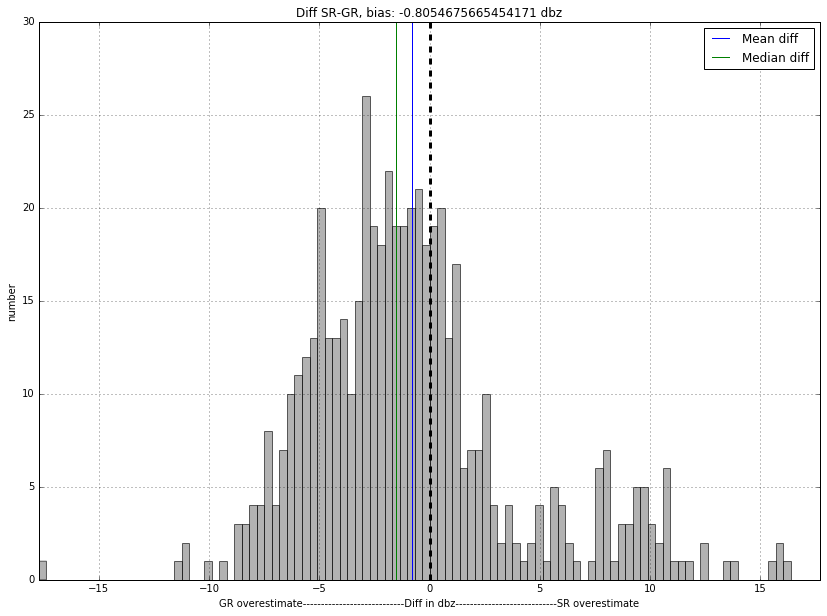

In [19]:
mm = ~np.isnan(GR)& ~np.isnan(SR)
pl.figure(figsize=(14,10))

pl.hist(SR[mm]-GR[mm],bins=100, facecolor="grey", alpha=0.6)
pl.axvline(np.mean(SR[mm]-GR[mm]), color='blue', label='Mean diff')
pl.axvline(np.median(SR[mm]-GR[mm]), color='green', label='Median diff')
pl.axvline(0, color='black',ls='--',lw=3)

xmin, xmax = np.nanmin(SR[mm]-GR[mm]), np.nanmax(SR[mm]-GR[mm])
limits = np.nanmax([abs(xmin),abs(xmax)])
pl.xlim(-limits,limits)

pl.title('Diff SR-GR, bias: '+str( np.sum(SR[mm]-GR[mm])/len(SR[mm]-GR[mm]))+' dbz')
pl.grid()
pl.legend()
pl.xlabel('GR overestimate----------------------------Diff in dbz----------------------------SR overestimate')
pl.ylabel('number')
pl.savefig('/automount/ftp/velibor/validation/matching_bias.png')

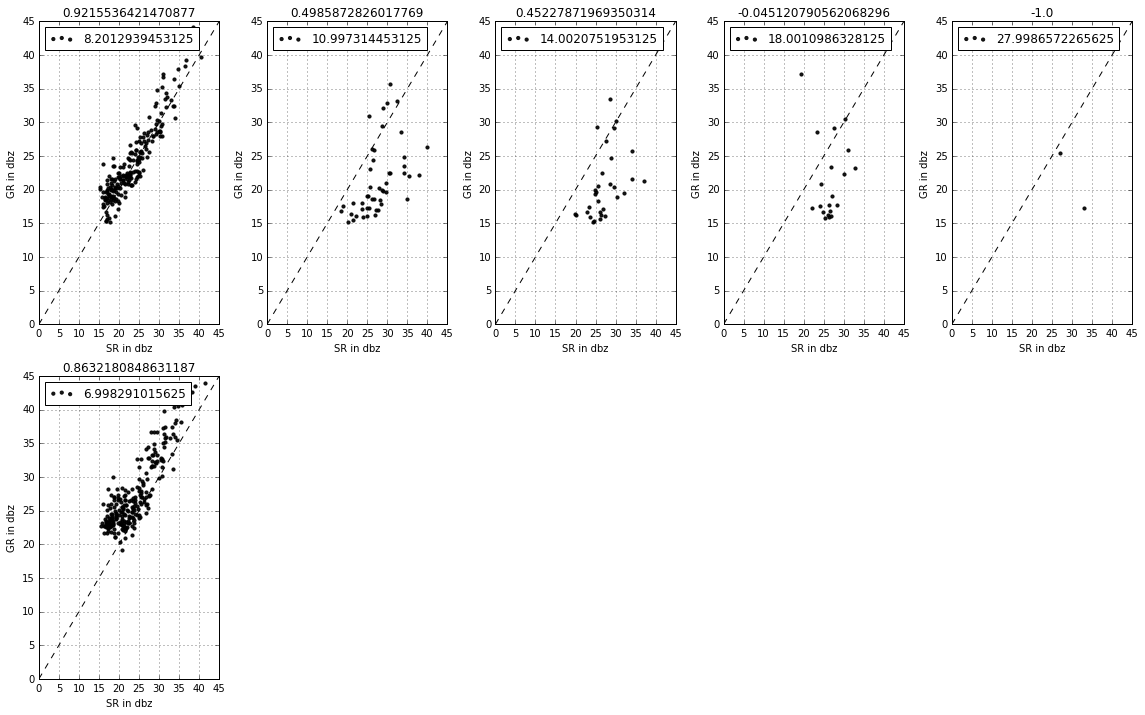

In [20]:
aa=0.9
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)

pl.figure(figsize=(16,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(SR[0:e_pos[0]],GR[0:e_pos[0]],alpha=aa,label=str(gr_ele[0]),color='black',s=10)
        pl.title(corcor(SR[0:e_pos[0]],GR[0:e_pos[0]]))
        pl.legend(loc='upper left')
    else:
        pl.scatter(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]],alpha=aa,
                   label=str(gr_ele[eee]),color='black',s=10)
        pl.title(corcor(SR[e_pos[eee-1]:e_pos[eee]],GR[e_pos[eee-1]:e_pos[eee]]))
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(0,45)
    pl.ylim(0,45)
    pl.plot([0,45],[0,45], color='black', ls='--')

pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_elev.png')

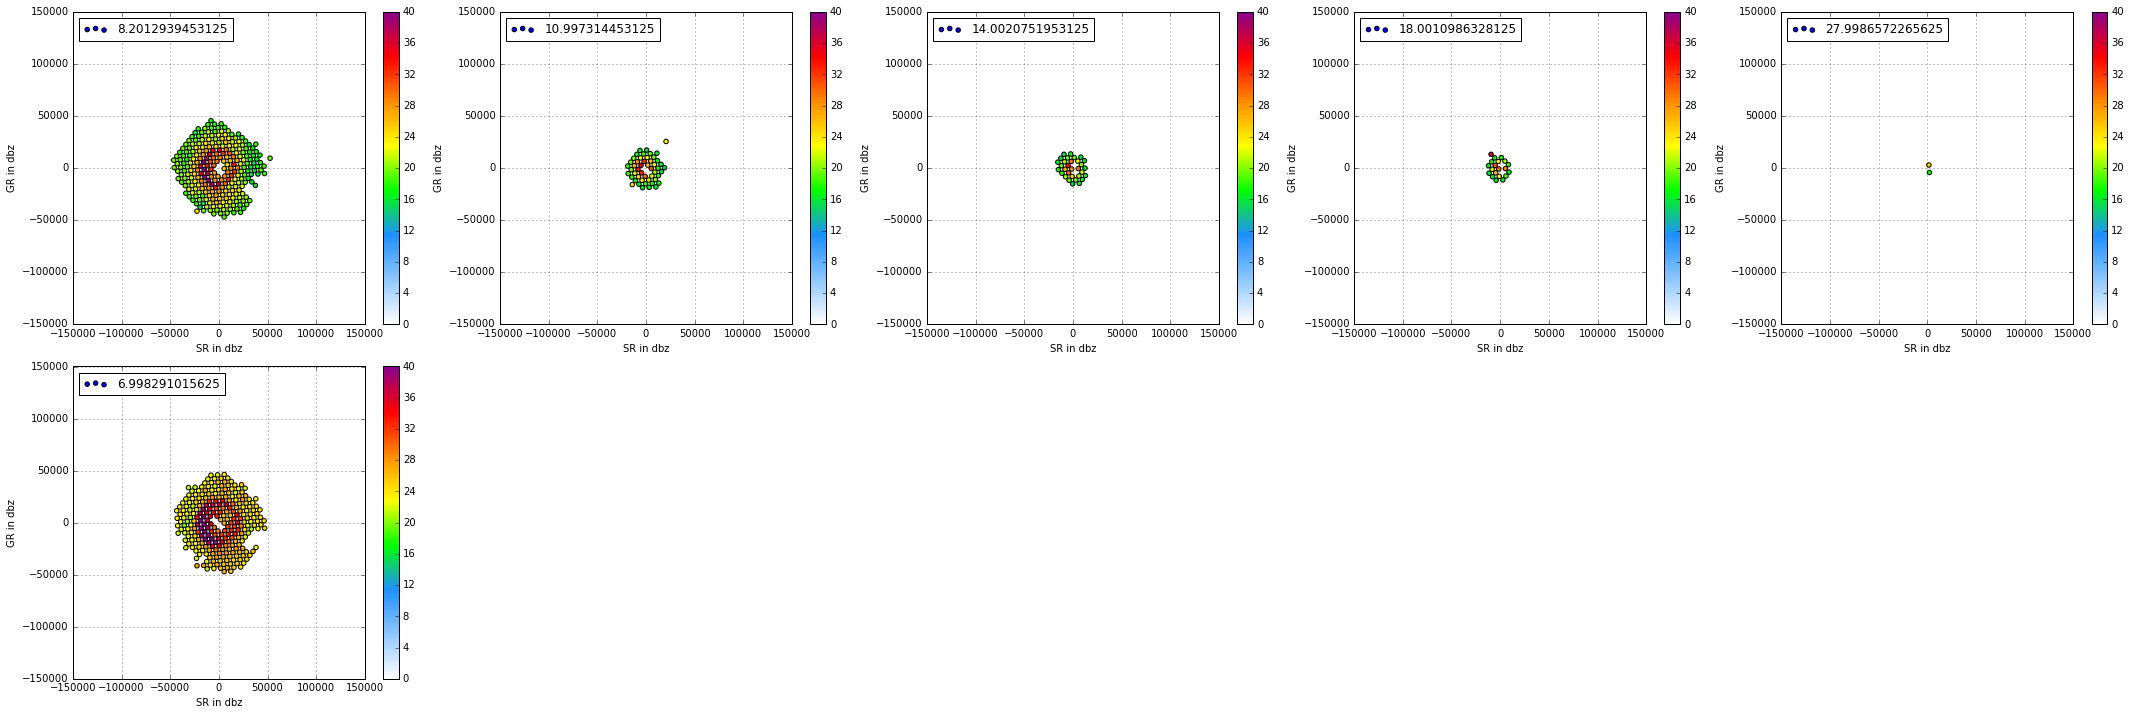

In [21]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_ppiGR.png')



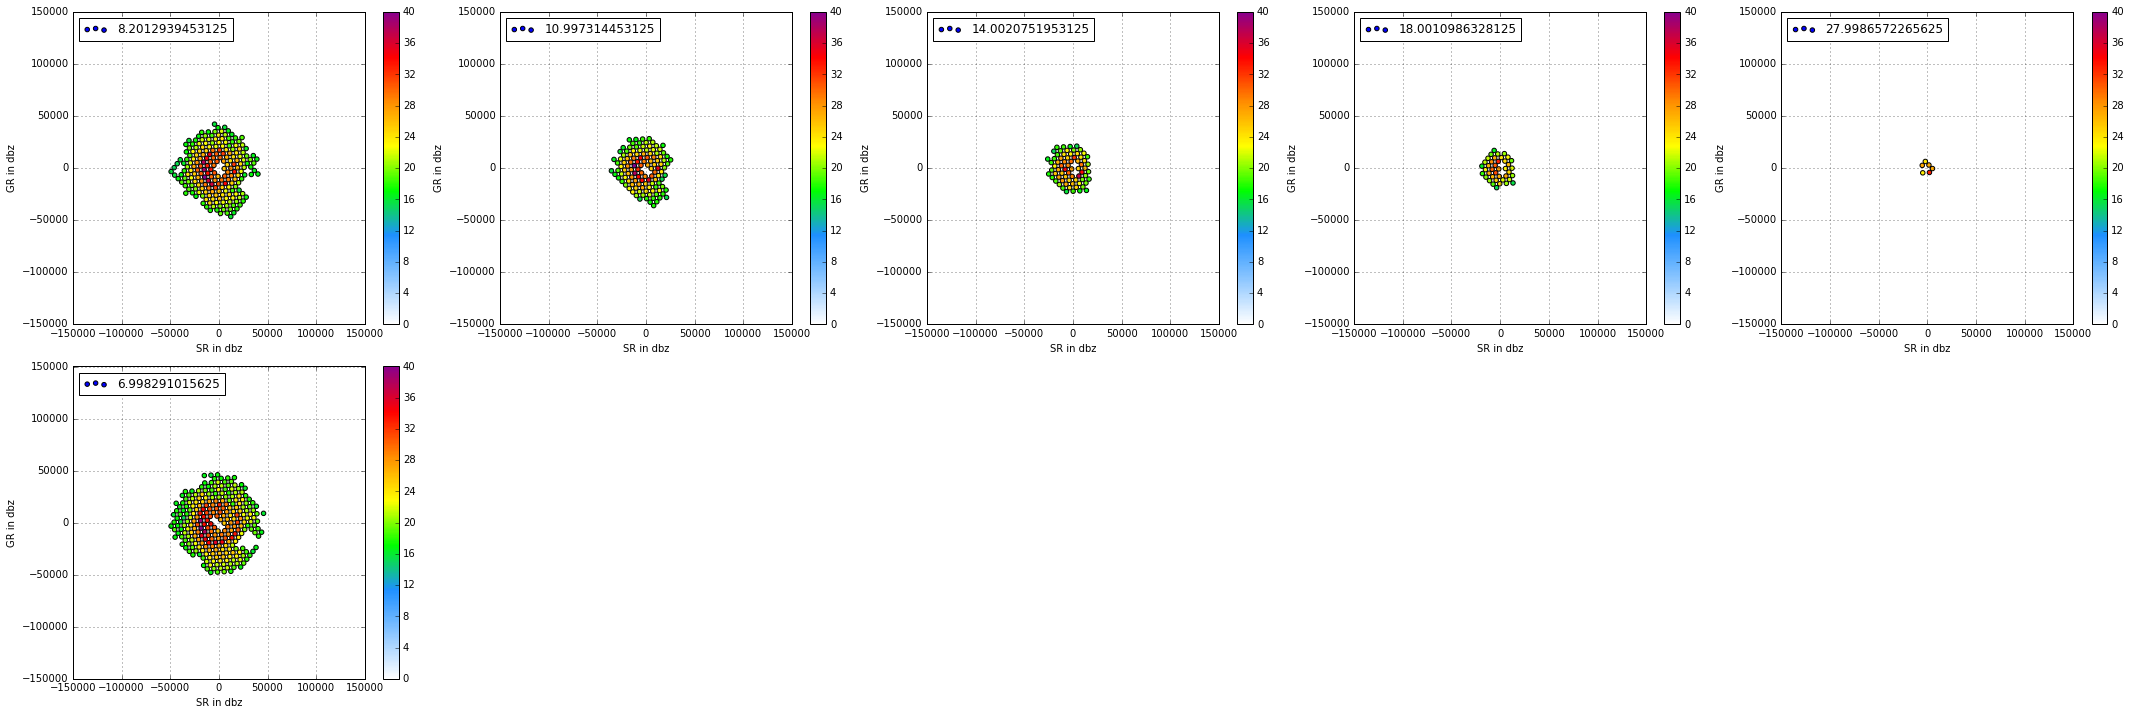

In [22]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Y[0:e_pos[0]],c=SR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Y[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(-150000,150000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_ppiSR.png')



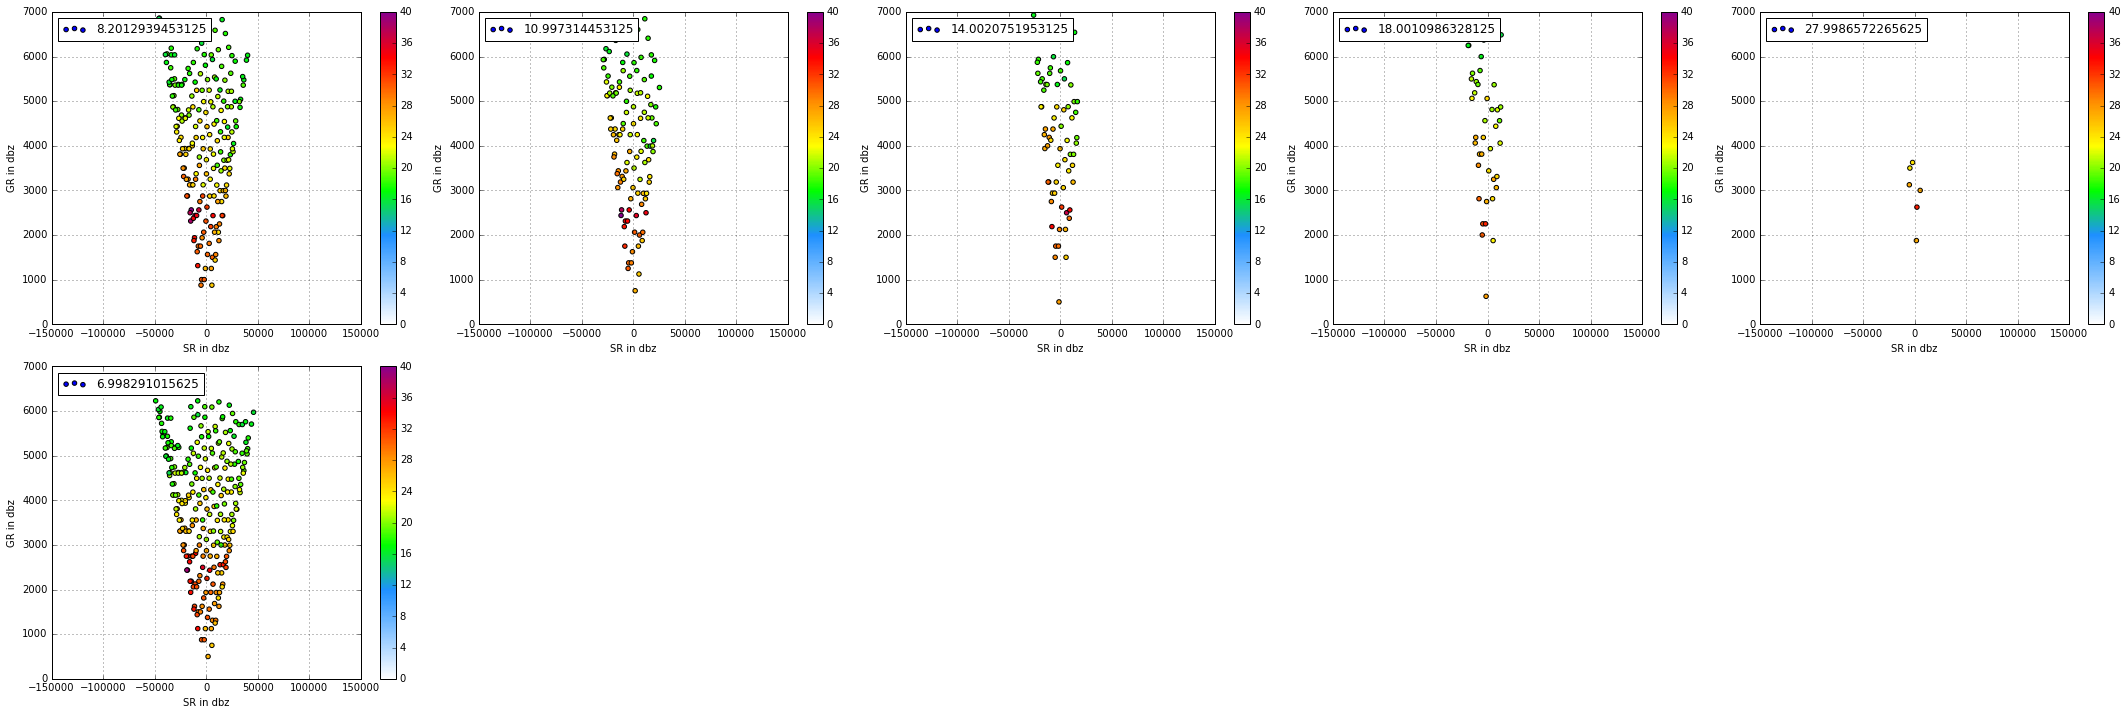

In [23]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=SR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=SR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(0,7000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_XppiSR.png')



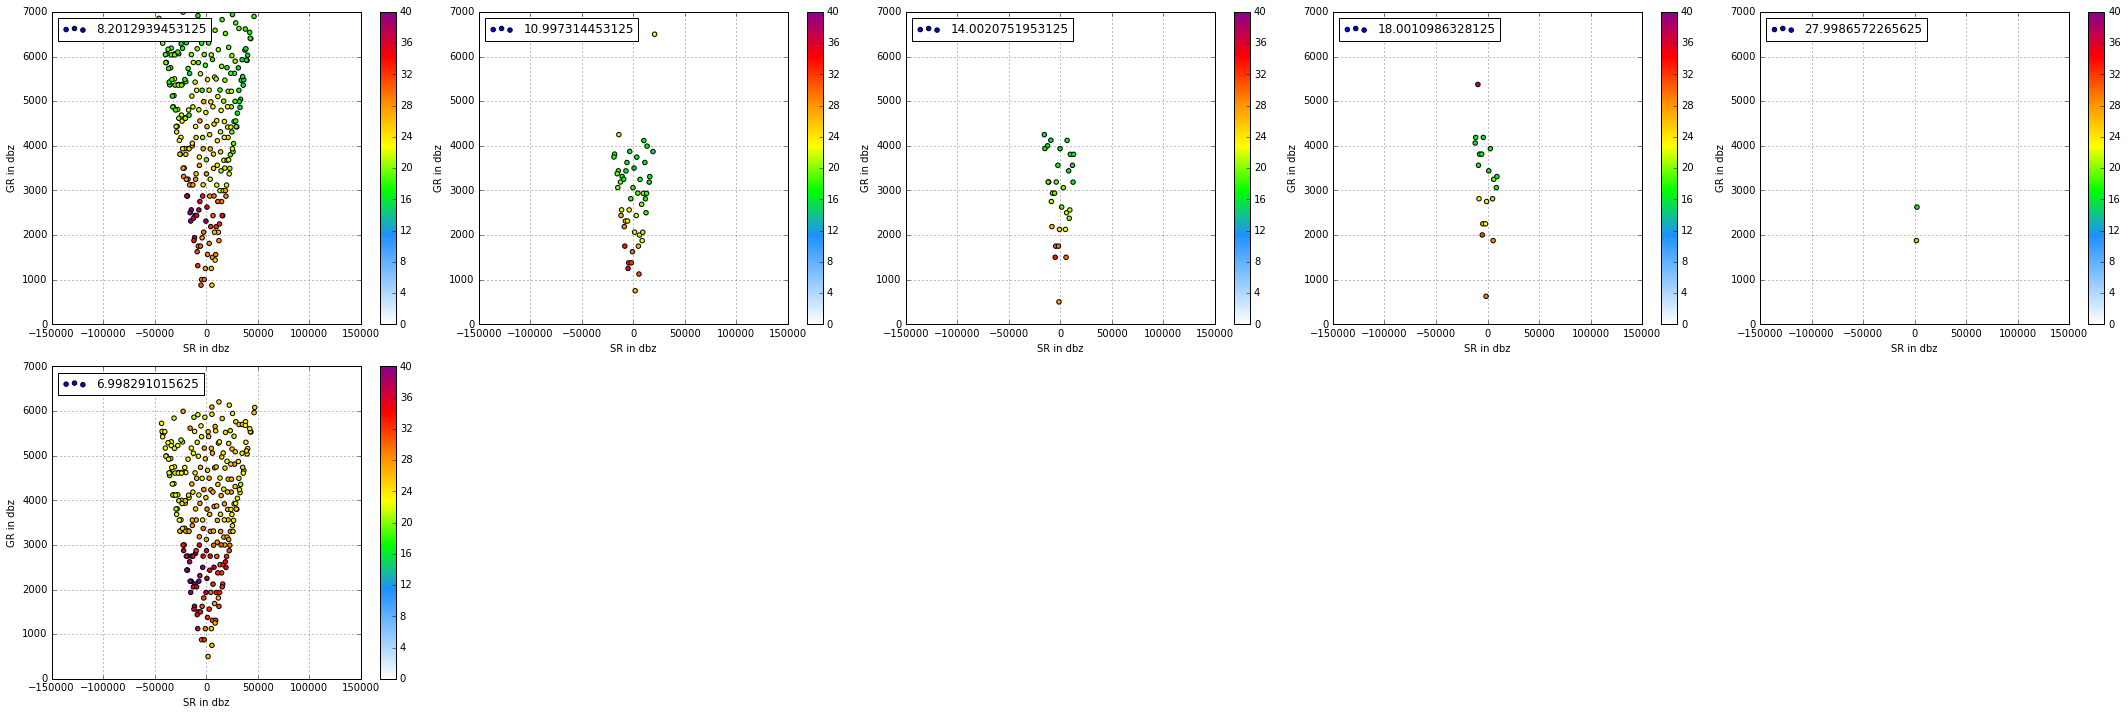

In [24]:
# Elevation unterteilen mit Cumulativer Summe
e_pos = gr_nr_elev.cumsum().astype(int)
from pcc import get_miub_cmap

pl.figure(figsize=(30,10))

for eee in range(len(gr_nr_elev)):
    pl.subplot(2,5,eee+1)
    
    if eee==0: 
        pl.scatter(X[0:e_pos[0]],Z[0:e_pos[0]],c=GR[0:e_pos[0]],label=str(gr_ele[0]),
                   cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    else:
        pl.scatter(X[e_pos[eee-1]:e_pos[eee]],Z[e_pos[eee-1]:e_pos[eee]],c=GR[e_pos[eee-1]:e_pos[eee]],
                   label=str(gr_ele[eee]), cmap=get_miub_cmap(), vmin=0, vmax=40)
        pl.legend(loc='upper left')
    pl.xlabel('SR in dbz')
    pl.ylabel('GR in dbz')
    pl.grid()
    pl.xlim(-150000,150000)
    pl.ylim(0,7000)
    pl.colorbar()


pl.tight_layout()
pl.savefig('/automount/ftp/velibor/validation/corr_XppiGR.png')



In [25]:
np.nanmin(ref_sr)

14.53